## Neural Machine Translation  with attention practice on french to english DS

### Code is heavily based on the tensorflow tutorial found at this link

https://www.tensorflow.org/tutorials/text/nmt_with_attention


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Softmax, Embedding
from tensorflow.keras import Sequential
from matplotlib import pyplot as plt
import numpy as np
import pickle
import random
import unicodedata
import os
import re

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
os.chdir("./drive/MyDrive/Colab Notebooks")

## Download data

In [3]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip'
raw_data_path = tf.keras.utils.get_file(
          "eng_french_raw_data",
          url,
          extract=True)

data_path = os.path.join(os.path.dirname(raw_data_path), 'fra.txt')


## Preprocess Data

In [4]:
# preserve accents
def normalize_unicode(s):
  """ Used to preserve characters with accents """
  return ''.join(c for c in unicodedata.normalize('NFC', s))

# delete accents
def normalize_unicode(s):
  """ Used to delete characters with accents """
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def read_file(path):
  with open(path, "r", encoding="UTF-8") as f:
    return f.read()


def preprocess_sentence(w):
  # punctuations to preserve (".", "?", "!", ",")
  
  # lower the case
  w = w.lower()
  
  # normalize unicode 
  w = normalize_unicode(w)

  # padding punctuation with spaces
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([.!,?])", r" \1 ", w)

  # replace long white spaces with a single space
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, punctuations to save)
  #w = re.sub(r"[^a-z.!,'?]+", " ", w)

  # remove strip trailing and ending spaces
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


def tokenize(list_of_sentences):
  tokenizer = Tokenizer(filters='',
                        split=' ', 
                        char_level=False,
                        oov_token="<oov>")
  tokenizer.fit_on_texts(list_of_sentences)
  tokenized_sentences = tokenizer.texts_to_sequences(list_of_sentences)
  tokenized_sentences = pad_sequences(tokenized_sentences, padding='post')

  return tokenized_sentences, tokenizer


def preprocess_data(path, train_split=0.8, dataset_fraction=0.4):
  """
    preprocess data

    Adjust dataset_fraction to increase or reduce dataset and subsequently
    vocabulary size depending on compute resources

    Args:
      path (str): path to text file / data
      train_split (float): train/test split
      dataset_fraction (float): fraction of the full dataset to train on

    Return:
      (tuple): lists with train and test sentences of source and target 
                languages with their tokenizers 
  """
  # read data 
  input_data_as_string = read_file(path)

  # preprocess data for tokenizer - list of list of sentences
  input_data = [[preprocess_sentence(sentence) for sentence in line.split("\t")] \
                  for line in input_data_as_string.split("\n")\
                  if len(line.split("\t")) == 2]

  english_sentences, target_lang_sentences = list(zip(*input_data))
  size_of_data = len(english_sentences)
  data_indices = np.arange(size_of_data)
  np.random.shuffle(data_indices)
  data_indices = data_indices[:int(size_of_data * dataset_fraction)]
  split_point = int(train_split * len(data_indices))
  train_idx, test_idx = data_indices[:split_point], data_indices[split_point:]
  
  # tokenize
  tokenized_english_sentences, english_tokenizer = tokenize(english_sentences)
  tokenized_target_lang_sentences, target_lang_tokenizer = tokenize(target_lang_sentences)

  return  tokenized_english_sentences[train_idx], \
          tokenized_english_sentences[test_idx], \
          tokenized_target_lang_sentences[train_idx], \
          tokenized_target_lang_sentences[test_idx], \
          english_tokenizer, \
          target_lang_tokenizer


def display_sample_sentences(num_of_samples, 
                             tokenized_english_sentences,
                             tokenized_target_lang_sentences,
                             english_tokenizer,
                             target_lang_tokenizer,
                             target_lang="French"):
  num_of_words_not_oov = np.sum(tokenized_english_sentences != 0, axis=1)
  indices_of_top_words_in_vocab = np.argsort(num_of_words_not_oov)[::-1][:num_of_samples]
  sample_english_tokens = tokenized_english_sentences[indices_of_top_words_in_vocab]
  sample_target_lang_tokens = tokenized_target_lang_sentences[indices_of_top_words_in_vocab]
  sample_english_sentences = english_tokenizer.sequences_to_texts(sample_english_tokens)
  sample_target_lang_sentences = target_lang_tokenizer.sequences_to_texts(sample_target_lang_tokens)
  for eng, targ_lang in zip(sample_english_sentences, sample_target_lang_sentences):
    print(f"English: {eng}")
    print(f"{target_lang}: {targ_lang} \n")

In [5]:
train_eng_sen, test_eng_sen, train_french_sen, test_french_sen,\
          english_tokenizer, french_tokenizer = preprocess_data(data_path)

In [6]:
display_sample_sentences(3,
                         train_eng_sen,
                         train_french_sen,
                         english_tokenizer,
                         french_tokenizer)

English: <start> top-down economics never works , said obama . the country does not succeed when just those at the very top are doing well . we succeed when the middle class gets bigger , when it feels greater security . <end> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>
French: <start> « l'economie en partant du haut vers le bas , ca ne marche jamais , » a dit obama . « le pays ne reussit pas lorsque seulement ceux qui sont au sommet s'en sortent bien . nous reussissons lorsque la classe moyenne s'elargit , lorsqu'elle se sent davantage en securite . » <end> <oov> <oov> <oov> <oov> <oov> 

English: <start> a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities . some people try to reduce their carbon footprint because they are concerned about climate change . <end> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>
French: <start> une empreinte carbone est la somme de 

## Batch Data and Hyperameters

In [7]:
num_train, NUM_INP_TIMESTEPS = train_eng_sen.shape
_, NUM_TARG_TIMESTEPS = test_eng_sen.shape
BUFFER_SIZE = num_train
BATCH_SIZE = 32
STEPS_PER_EPOCH = num_train//BATCH_SIZE
EMBED_DIMS = 256
UNITS = 1024
ATTENTION_DIMS = 10
VOCAB_INP_SIZE = len(english_tokenizer.word_index) + 1 #to account for padding
VOCAB_TARG_SIZE = len(french_tokenizer.word_index) + 1
LEARNING_RATE = 1e-3
EPOCHS = 30

sparse_cat_lossfn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train_data = tf.data.Dataset.from_tensor_slices((train_eng_sen, train_french_sen)).shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((test_eng_sen, test_french_sen)).shuffle(BUFFER_SIZE)
test_data = test_data.batch(BATCH_SIZE)

def loss_fn(targets, outputs, sparse_cat_lossfn=sparse_cat_lossfn):
  loss = sparse_cat_lossfn(targets, outputs)
  mask = tf.cast(targets != 0, loss.dtype)
  return tf.reduce_mean(loss * mask)

def disp_sentence(x):
   return " ".join(i for i in x.split(" ") if i not in ['<start>', '<oov>', '<end>'])

## Model

In [8]:
class AttentionLayer(tf.keras.Model):
  def __init__(self, attention_hidden_dims):
    super(AttentionLayer, self).__init__()
    self.W1 = Dense(attention_hidden_dims)
    self.W2 = Dense(attention_hidden_dims)
    self.V = Dense(1)
    self.softmax = Softmax(axis=1)

  def call(self, query_decoder, key_encoder):
    query_decoder = tf.expand_dims(query_decoder, 1)
    o = tf.keras.activations.tanh(
            self.W1(query_decoder) + self.W2(key_encoder))
    o = self.V(o)
    attention_weights = self.softmax(o)
    temp = tf.reduce_sum(attention_weights * key_encoder, axis=1)
    context_vector = tf.expand_dims(temp, axis=1)
    return attention_weights, context_vector


class Encoder(tf.keras.Model):
  def __init__(self, units, vocab_size, emb_dims):
    super(Encoder, self).__init__()
    self.lstm_layer = LSTM(units, return_state=True, return_sequences=True)
    self.embedding_layer = Embedding(vocab_size, 
                                     emb_dims, 
                                     mask_zero=True)

  def call(self, inputs):
    inputs = self.embedding_layer(inputs)
    hidden_state_sequence, final_hidden_state, final_cell_state = self.lstm_layer(inputs)
    final_states = [final_hidden_state, final_cell_state]
    return hidden_state_sequence, final_states


class Decoder(tf.keras.Model):
  def __init__(self, units, vocab_size, emb_dims):
    super(Decoder, self).__init__()
    self.lstm_layer = LSTM(units, return_state=True, return_sequences=True)
    self.embedding_layer = Embedding(vocab_size, 
                                     emb_dims, 
                                     mask_zero=True)
    self.output_layer = Dense(vocab_size)

  def call(self, 
           inputs, 
           context_vector,
           previous_states):

    if len(inputs.shape) == 1:
      inputs = tf.expand_dims(inputs, axis=1)
    inputs = self.embedding_layer(inputs)
    inputs = tf.concat([inputs, context_vector], axis=-1)
    _, next_hidden_state, next_cell_state = self.lstm_layer(inputs, \
                                            initial_state=previous_states)
    output = self.output_layer(next_hidden_state)
    next_states = [next_hidden_state, next_cell_state]
    return next_states, output


class NMT(tf.keras.Model):
  def __init__(self, units, 
               enc_vocab_size, 
               dec_vocab_size,
               emb_dims, 
               attention_hidden_dims, 
               decoder_tokenizer):
    
    super(NMT, self).__init__()
    self.units = units
    self.encoder = Encoder(units, enc_vocab_size, emb_dims)
    self.decoder = Decoder(units, dec_vocab_size, emb_dims)
    self.attention_layer = AttentionLayer(attention_hidden_dims)
    self.decoder_tokenizer = decoder_tokenizer

  def call(self, 
           model_inputs,
           max_timesteps = NUM_TARG_TIMESTEPS,
           eval=False):
    
      inputs, targets = model_inputs
      bs, _ = inputs.shape
      loss = 0
      hidden_state_sequence, input_states = self.encoder(inputs)
      query_decoder = input_states[0] # select hidden state
      predicted_outputs = []
      attention_weights_list = []
      
      dec_input = self.decoder_tokenizer.texts_to_sequences(['<start>'])
      dec_input = tf.constant(dec_input * bs)      

      for i in range(1, max_timesteps):
        attention_weights, context_vector = self.attention_layer(query_decoder, hidden_state_sequence)
        input_states, outputs = self.decoder(dec_input, context_vector, input_states)
        if eval:
          dec_input = tf.argmax(outputs, axis=1)
        else:
          dec_input = targets[:, i] # dec input for next stage is target for this stage

        query_decoder = input_states[0]
        loss += loss_fn(dec_input, outputs)
        
        
        if eval:
          predictions = tf.expand_dims(dec_input, 1)
          predictions = self.decoder_tokenizer.sequences_to_texts(predictions.numpy())
          predicted_outputs.append(predictions)
          attention_weights_list.append(attention_weights.numpy())

      loss /= max_timesteps

      if len(attention_weights_list) != 0:
        predicted_outputs = np.array(predicted_outputs).T
        attention_weights = np.stack(attention_weights_list, axis=2)[..., -1]
                                      
      return loss, predicted_outputs, attention_weights


In [9]:
sparse_cat_lossfn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.NONE)


@tf.function
def train_model(model, optimizer, inputs, targets):
  with tf.GradientTape() as tape:
    loss, prediction, attention_weights = model((inputs, targets))

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, prediction, attention_weights


## Checkpoints

In [10]:
checkpoint_directory = "./checkpoints"
stats_save_path = os.path.join(checkpoint_directory, "train_stats.pkl")

def save_pickled_data(data, data_path):
    """Saves a pickle file"""
    if os.path.exists(data_path):
      os.remove(data_path)

    with open(data_path, "wb") as f:
        data = pickle.dump(data, f)
    return data


def load_pickled_data(data_path):
    """Reads a pickle file"""
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data


optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
nmt_model = NMT(UNITS, VOCAB_INP_SIZE, VOCAB_TARG_SIZE, EMBED_DIMS, ATTENTION_DIMS, french_tokenizer)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, nmt_model=nmt_model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_directory, max_to_keep=2)

status = checkpoint.restore(manager.latest_checkpoint)

In [11]:
resume_epoch = max([1] + [int(i.split('.')[0].split("-")[1]) \
                          for i in os.listdir('checkpoints') \
                          if 'ckpt' in i])
train_stats = []
for epoch in range(resume_epoch, EPOCHS + 1):
  train_epoch_loss = []
  val_epoch_loss = []
  attention_weights_list = []
  prediction_list = []
  for i, (inp, targ) in enumerate(train_data):
    loss, _, _ = train_model(nmt_model, optimizer, inp, targ)
    train_epoch_loss.append(loss.numpy())

  for i, (inp, targ) in enumerate(test_data):
    loss, prediction, attention_weights = nmt_model((inp, targ), eval=True)
    attention_weights_list.append(attention_weights)
    prediction_list.append(prediction)
    val_epoch_loss.append(loss.numpy())
  
  inp_text = english_tokenizer.sequences_to_texts(inp.numpy())
  targ_text = nmt_model.decoder_tokenizer.sequences_to_texts(targ.numpy())

  #status.assert_consumed()  # Optional sanity checks.
  manager.save()
  
  if epoch % 5 == 1:
    for idx in np.random.randint(0, len(inp_text), 5):
      pred = list(prediction[idx])
      pred_index = pred.index('<end>') if '<end>' in pred else len(pred)
      prediction_text = " ".join(pred[:pred_index])
      print(f"input: {disp_sentence(inp_text[idx])}")
      print(f"target: {disp_sentence(targ_text[idx])}")
      print(f"prediction: {prediction_text} \n")
  
  train_epoch_loss = np.mean(train_epoch_loss)
  val_epoch_loss = np.mean(val_epoch_loss)
  train_stats.append({'epoch': epoch, 'train_loss':train_epoch_loss, 'val_loss':val_epoch_loss})
  save_pickled_data(train_stats, stats_save_path)
  print(f"Epoch {epoch}, train loss: {train_epoch_loss} val loss: {val_epoch_loss}\n")


input: he constantly criticizes other people .
target: il est toujours en train de critiquer les autres .
prediction: il a ete arrete de la mort . 

input: that's not your fault .
target: ce n'est pas de ta faute .
prediction: ce n'est pas ton affaire . 

input: let me get you the key .
target: laissez-moi vous degoter la cle .
prediction: laissez-moi te donner une minute . 

input: he constantly criticizes other people .
target: il est toujours en train de critiquer les autres .
prediction: il a ete arrete de la mort . 

input: he constantly criticizes other people .
target: il est toujours en train de critiquer les autres .
prediction: il a ete arrete de la mort . 

Epoch 1, train loss: 0.5171830654144287 val loss: 0.6077547669410706

Epoch 2, train loss: 0.3890637457370758 val loss: 0.5316329002380371

Epoch 3, train loss: 0.29100582003593445 val loss: 0.4404694139957428

Epoch 4, train loss: 0.21251094341278076 val loss: 0.28914323449134827

Epoch 5, train loss: 0.15326382219791412

## Evaluation

In [12]:
def prep_text_for_eval(x, tokenizer=english_tokenizer):
  list_of_sentences = x.split(".")
  list_of_sentences = [sen + "." for sen in list_of_sentences]
  inp = [preprocess_sentence(i) for i in list_of_sentences]
  inp = tokenizer.texts_to_sequences(inp)
  inp = pad_sequences(inp, maxlen= NUM_INP_TIMESTEPS, padding='post')
  return inp

def display_prediction(prediction):
  pred = []
  for line in prediction:
    pred_index = np.where(line == '<end>')[0][0]
    pred.extend(list(line[:pred_index]))
  return " ".join(pred)

def query_preprocessor(inp, english_tokenizer=english_tokenizer):
  if tf.is_tensor(inp):
    query = english_tokenizer.sequences_to_texts(inp.numpy())
    query = np.array(query)
  elif type(inp) is np.ndarray and np.issubdtype(inp.dtype, np.integer):
    query = english_tokenizer.sequences_to_texts(inp)
    
  return query

In [41]:
def display_attention(query, attention, prediction, base_size):
  
  num_plots, query_size, pred_size = attention.shape
  
  num_rows = num_plots//2 if num_plots % 2 == 0 else num_plots//2 + 1
  rows = base_size * num_rows
  cols = 2 * base_size
  fig = plt.figure(figsize=(rows, cols))
  
  input_sentences = []
  for i in range(1, num_plots + 1):
    
    pred = prediction[i-1]
    pred_index = np.where(pred == '<end>')[0][0]
    pred = pred[:pred_index]
    
    
    que = query[i-1].split(" ")
    query_index = que.index('<end>') if '<end>' in que else len(que)
    que = np.array(que)[1:query_index]
    input_sentences.append(" ".join(que))
    
    att_matrix = attention[i-1]
    att_matrix = att_matrix[1:query_index,:pred_index]
    

    ax = fig.add_subplot(num_rows, 2, i)
    ax.matshow(att_matrix, cmap='viridis')
    ax.set_xticks(np.arange(len(pred)))
    ax.set_yticks(np.arange(len(que)))
    ax.set_xticklabels(pred)
    ax.set_yticklabels(que)

  input_sentences = " ".join(input_sentences)
  print(f"input: {input_sentences}")
  plt.show()

def prep_and_eval(inp, targ=None, base_size=10):
  if type(inp) is str:
    inp = prep_text_for_eval(inp)

  _, prediction, attention = nmt_model((inp, targ), eval=True)
  query = query_preprocessor(inp)
  print(f"prediction: {display_prediction(prediction)}")
  display_attention(query, attention, prediction, base_size)

## Random Input

prediction: c'est un homme honnete .
input: he is a honest man .


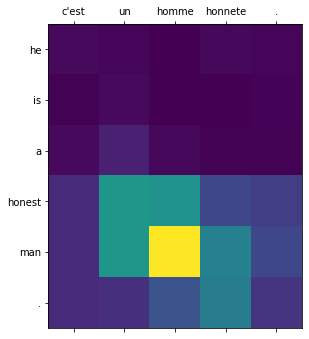

In [50]:
input_sentence = "He is a honest man"
prep_and_eval(input_sentence)

In [15]:
test_data_ = test_data.take(5)
sample_test_data = list(test_data.as_numpy_iterator())

## Test set input

prediction: c'etait une erreur .
input: it was a mistake .


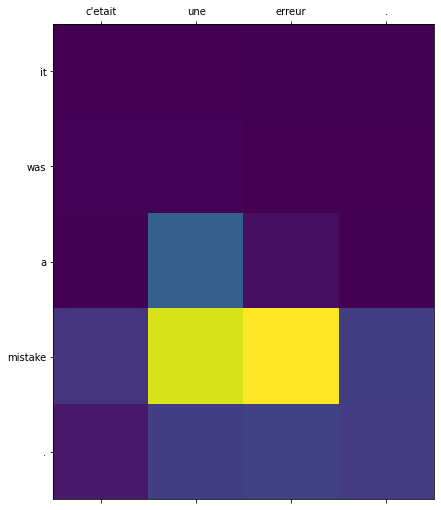

In [48]:
idx = 6
num_samples = 1
inp, targ = sample_test_data[idx]
inp = inp[:num_samples]
targ = inp[:num_samples]
prep_and_eval(inp, targ, 15)